In [ ]:
%%capture
!pip install --upgrade pip
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes
!pip install matplotlib

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-Coder-0.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Адаптеры LoRA
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.12/dist-packages/unsloth/models/rl_replacements.py:946: UserWarning: You are importing from 'trl.experimental'. APIs here are unstable and may change or be removed without notice. Silence this warning by setting environment variable TRL_EXPERIMENTAL_SILENCE=1.
  import trl.experimental.openenv.utils as openenv_utils


==((====))==  Unsloth 2025.12.4: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/457M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth 2025.12.4 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


In [ ]:
from datasets import load_dataset
from unsloth import get_chat_template

# 1. Токенизатор ChatML
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping = {"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
)

def formatting_prompts_func(examples):
    convos = []
    for q, r in zip(examples["query"], examples["response"]):
        conversation = [
            {"role": "system", "content": "You are a helpful coding assistant that solves LeetCode problems."},
            {"role": "user", "content": q},
            {"role": "assistant", "content": r},
        ]
        text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
        convos.append(text)

    return { "text" : convos }

# Датасет
dataset = load_dataset("newfacade/LeetCodeDataset")
dataset = dataset.map(formatting_prompts_func, batched = True)

print(dataset["train"][0]["text"][:500])

Unsloth: Will map <|im_end|> to EOS = <|im_end|>.


README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

LeetCodeDataset-train.jsonl:   0%|          | 0.00/93.6M [00:00<?, ?B/s]

LeetCodeDataset-test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/2641 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/228 [00:00<?, ? examples/s]

Map:   0%|          | 0/2641 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

<|im_start|>system
You are a helpful coding assistant that solves LeetCode problems.<|im_end|>
<|im_start|>user
You are an expert Python programmer. You will be given a question (problem specification) and will generate a correct Python program that matches the specification and passes all tests.

### Question:
Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.
You may assume that each input would have exactly one solution, a


In [34]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

os.environ["WANDB_DISABLED"] = "true"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 3,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy = "steps",
        eval_steps = 5,
    ),
)

trainer_stats = trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,641 | Num Epochs = 3 | Total steps = 993
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 8,798,208 of 502,830,976 (1.75% trained)

Unsloth: Will smartly offload gradients to save VRAM!

[993/993 6:26:23, Epoch 3/3] 

| Step   | Training Loss   | Validation Loss |
|--------|-----------------|-----------------|
| 5      | 1.107500        | 1.172920        |
| 10     | 0.892700        | 1.039561        |
| 15     | 0.593400        | 0.841806        |
| 20     | 0.561400 

/tmp/ipython-input-557755054.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = df['loss'].rolling(window=window_size, center=True).median().fillna(method='bfill').fillna(method='ffill')


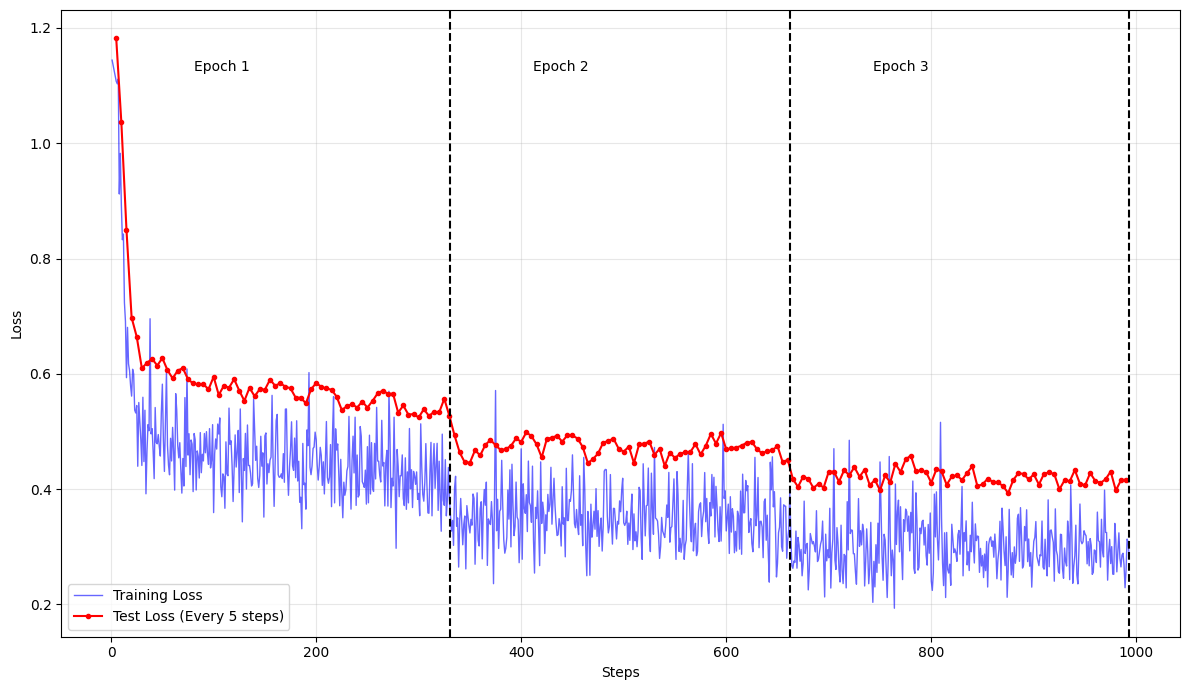

In [1]:
import matplotlib.pyplot as plt
history = trainer.state.log_history
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []
for entry in history:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry and "step" in entry:
        eval_steps.append(entry["step"])
        eval_losses.append(entry["eval_loss"])
plt.figure(figsize=(12, 7))
plt.plot(train_steps, train_losses, linewidth=1, alpha=0.6, label='Training Loss')
plt.plot(eval_steps, eval_losses, color='red', linewidth=1.5, marker='o', markersize=3, label='Test Loss (Every 5 steps)')
epochs = 3
steps_per_epoch = 331
max_loss_val = train_losses.max()
for i in range(1, epochs + 1):
    epoch_step = i * steps_per_epoch
    if epoch_step <= 939:
        plt.axvline(x=epoch_step, color='black', linestyle='--')
        plt.text(epoch_step - 250, max_loss_val, f'Epoch {i}',
                 fontsize=10, color='black', verticalalignment='top')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
model.save_pretrained_gguf("qwen2.5-coder-7b-leetcode",tokenizer,quantization_method = "q4_0")


Unsloth: Merging model weights to 16-bit format...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.

Unsloth: Preparing safetensor model files:   100%|██████████|1/1 [04:03<00:00, 247.09s/it]
model.safetensors:   100%|██████████| 988/988M [01:02<00:00, 62.35s/it]
Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:23<00:00, 23.78s/it]
Note: tokenizer.model not found (this is OK for non-SentencePiece models)
Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:15<00:00, 15.89s/it]
Unsloth: Merge process complete. Saved to `/content/qwen2.5-coder-7b-leetcode`
Unsloth: Converting to GGUF for